In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from classification_utils import *

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.ensemble import VotingClassifier

%matplotlib inline


#from keras.preprocessing.text import Tokenizer, text_to_word_sequence, one_hot

#from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# set random number generator's seed:
np.random.seed(957)

This function loads the data from a CSV file into panda dataframe:

In [3]:
def load_dataset(filepath):
    data_frame = pd.read_csv(filepath, usecols=['id', 'text', 'intent'])
    data_frame = data_frame.sample(frac=1).reset_index(drop=True)  # shuffle the dataset for better performance in case it's sorted
    return data_frame

load_from_database()
dataset = load_dataset("data/classifier_ds.csv")
dataset.tail()

,id,text,intent
8231,362.0,am always online :P,none
8232,6870.0,thank you Mourad,none
8233,6192.0,"yes ,but i don't mean that there are bridges",discuss_task
8234,3502.0,Do we have to fill the tables?,query_plan
8235,1744.0,"I also replied to your requirements, there wer...",request_feedback


In [4]:
dataset.drop(['id'], axis=1).describe()

,text,intent
count,8236,8236
unique,7662,13
top,ok,none
freq,44,2617


In [5]:
# Drop low frequency tags
#dataset = dataset[~dataset.intent.isin(['report_issue'])]
# drop some samples from the 'other' class to make the classes more balanced
#indecies = dataset.index[dataset.intent.isin(['none'])]
#dataset = dataset.drop(np.random.choice(indecies, 1000, replace=False))
#indecies = dataset.index[dataset.tag.isin(['task'])]
#dataset = dataset.drop(np.random.choice(indecies, 1000, replace=False))

In [6]:
stats = dataset[['text','intent']].groupby('intent').count().sort_values(by=['text'])
stats

,text
intent,
report_issue,111
query_rules,122
query_plan,173
query_progress,188
state_rules,233
schedule_meeting,360
report_progress,465
give_feedback,468
request_feedback,488


<AxesSubplot:xlabel='intent'>

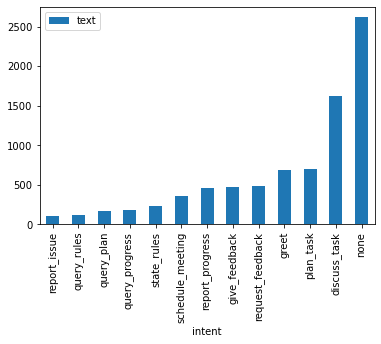

In [7]:
stats.plot.bar(ylim=0)

In [8]:
# filter for direct message intents
dm_man_intents = [
                    'greet', 'plan_task', 'query_plan', 'state_rules', 'query_rules', 
                    'query_progress', 'report_progress', 'schedule_meeting', 'give_feedback', 'none'
                 ]

dm_dev_intents = [
                    'greet', 'query_plan', 'query_rules', 'report_issue', 'give_feedback',
                    'query_progress', 'report_progress', 'schedule_meeting', 'request_feedback', 'none',
                 ]

dm_dataset = dataset[dataset.intent.isin(dm_man_intents)]
stats = dm_dataset[['text','intent']].groupby('intent').count().sort_values(by=['text'])
stats

,text
intent,
query_rules,122
query_plan,173
query_progress,188
state_rules,233
schedule_meeting,360
report_progress,465
give_feedback,468
greet,685
plan_task,701


In [9]:
X = np.reshape(dm_dataset['text'].values, (-1, 1))
Y = np.reshape(dm_dataset['intent'].values, (-1, 1))

In [10]:
# remove empty lines
dm_dataset['text'].dropna(inplace=True)
# remove CSV quotations
dm_dataset['intent'] = dm_dataset.intent.apply(lambda x: str(x).strip('"'))

<ipython-input-10-690726b4ede5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm_dataset['text'].dropna(inplace=True)
<ipython-input-10-690726b4ede5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm_dataset['intent'] = dm_dataset.intent.apply(lambda x: str(x).strip('"'))


In [11]:
entities = {
    'person': 'replace', 
    'subteam': 'replace', 
    'tool': 'replace', 
    'artifact': 'replace',
    'time': 'replace',
    'date': 'replace',
    'url': 'replace',
    'email': 'remove',
    'number': 'replace'
}

ids = []
text = []
first_person = []
second_person = []
third_person = []
past_count = []
present_count = []
future_count = []
q_scores = []
r_scores = []
s_scores = []
p_scores = []
n_scores = []
abs_len = []
intents = []

for _idx, row in dm_dataset.iterrows():
    txt, first, second, third, past, present, future, qscr, rscr, sscr, pscr, nscr, alen = normalize_msg(row.text, normal='none', remove_stop=False, entities=entities)
    ids.append(row.id)
    text.append(txt)
    first_person.append(first)
    second_person.append(second)
    third_person.append(third)
    past_count.append(past)
    present_count.append(present)
    future_count.append(future)
    q_scores.append(qscr)
    r_scores.append(rscr)
    s_scores.append(sscr)
    p_scores.append(pscr)
    n_scores.append(nscr)
    abs_len.append(alen)
    intents.append(row.intent)
    
nds = pd.DataFrame({
    'id': ids,
    'text': text,
    'first_person': first_person,
    'second_person': second_person,
    'third_person': third_person,
    'past_count': past_count,
    'present_count': present_count,
    'future_count': future_count,
    'que_score': q_scores,
    'req_score': r_scores,
    'sug_score': s_scores,
    'pos_score': p_scores,
    'neg_score': n_scores,
    'length': abs_len,
    'intent': intents
})
#nds['intent'] = dm_dataset['intent']
nds.dropna(inplace=True)
nds.tail()

,id,text,first_person,second_person,third_person,past_count,present_count,future_count,que_score,req_score,sug_score,pos_score,neg_score,length,intent
6007,6768.0,all as per my conversation today with george,1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,8,none
6008,3983.0,hi this MABotArtifact with information,0,0,0,0,1,0,0.0,0,0.0,0.0,0.0,5,none
6009,362.0,am always online p,0,0,0,0,2,0,0.0,0,0.0,0.0,0.0,4,none
6010,6870.0,thank you MABotPerson,0,1,0,0,1,0,0.0,0,0.0,0.0,0.0,3,none
6011,3502.0,do we have to fill the MABotArtifact ?,1,0,0,0,1,0,1.0,-1,0.0,-0.5,-0.5,8,query_plan


In [12]:
#Train_X_raw, Test_X_raw, Train_Y_raw, Test_Y_raw = train_test_split(nds.drop(['intent'], axis=1), nds['intent'], test_size=0.2)
#test_ids = Test_X_raw['id']
#test_ids.to_csv('test_ids.csv', index=False)

In [13]:
test_set_ids = pd.read_csv('test_ids.csv', header=None, names=['id'])
Train_raw = nds[~nds['id'].isin(test_set_ids['id'])]
Test_raw = nds[nds['id'].isin(test_set_ids['id'])]

Train_X_raw = Train_raw.drop(['intent'], axis=1)
Train_Y_raw = Train_raw['intent']
Test_X_raw = Test_raw.drop(['intent'], axis=1)
Test_Y_raw = Test_raw['intent']

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y_raw)
Test_Y = Encoder.fit_transform(Test_Y_raw)

In [14]:
pronoun_features = ['first_person', 'second_person', 'third_person']
tense_features = ['past_count', 'present_count', 'future_count']
length_features = ['length']
da_features = ['que_score', 'req_score', 'sug_score', 'pos_score', 'neg_score']

numeric_features = pronoun_features + tense_features + da_features + length_features
heuristic_selection = ['second_person', 'past_count', 'future_count', 'que_score', 'req_score', 'pos_score', 'length']

preprocessor = ColumnTransformer(
    [
        ('txt', TfidfVectorizer(max_features=4000, ngram_range=(1, 3)), 'text'),
        ('num1', MinMaxScaler(feature_range=(1, 10)), tense_features),
        ('num2', MinMaxScaler(feature_range=(1, 10)), pronoun_features),
        ('num3', MinMaxScaler(feature_range=(1, 10)), length_features),
        ('num4', MinMaxScaler(feature_range=(1, 20)), da_features)
        #('num5', MinMaxScaler(feature_range=(1, 10)), heuristic_selection)
    ])

preprocessor.fit(nds.drop(['intent','id'], axis=1))
Train_X = preprocessor.transform(Train_X_raw.drop(['id'], axis=1))
Test_X = preprocessor.transform(Test_X_raw.drop(['id'], axis=1))

print("Training set shape:",Train_X.shape)
print("Test set shape:",Test_X.shape)


intents = list(Encoder.inverse_transform([i for i in range(0, 10)]))

Training set shape: (4664, 4012)
Test set shape: (1129, 4012)


In [15]:
# Random Classifier
import random

accum = 0
dist = []
for intent in stats.index:
    count = stats['text'][intent]
    accum += count
    dist.append((accum, intent))

preds = []
for i in range(Test_Y.shape[0]):
    pred_i = random.randint(1, accum)
    for max_i, intent in dist:
        if pred_i <= max_i:
            preds.append(intent)
            break
    
pred_rand = Encoder.transform(preds)
# Use accuracy_score function to get the accuracy
print("Random Classifier Accuracy Score: %0.2f" % (accuracy_score(pred_rand, Test_Y) * 100))
print("Random Classifier Macro F1 Score: %0.3f" % (f1_score(pred_rand, Test_Y, average='macro')))
print("----------------------------------------------------------")
print(classification_report(Test_Y, pred_rand, target_names=intents))

Random Classifier Accuracy Score: 24.89
Random Classifier Macro F1 Score: 0.113
----------------------------------------------------------
                  precision    recall  f1-score   support

   give_feedback       0.11      0.11      0.11        84
           greet       0.14      0.14      0.14       143
            none       0.46      0.45      0.46       496
       plan_task       0.08      0.08      0.08       120
      query_plan       0.06      0.11      0.08        28
  query_progress       0.00      0.00      0.00        28
     query_rules       0.07      0.05      0.06        20
 report_progress       0.06      0.05      0.05       100
schedule_meeting       0.06      0.06      0.06        64
     state_rules       0.09      0.09      0.09        46

        accuracy                           0.25      1129
       macro avg       0.11      0.11      0.11      1129
    weighted avg       0.25      0.25      0.25      1129



### Naive Bayes Classifier

In [16]:
# fit the training dataset on the NB classifier
#Naive = naive_bayes.MultinomialNB()
Naive = naive_bayes.ComplementNB(alpha=2) #imbalanced dataset
Naive.fit(Train_X, Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score: %0.2f" % (accuracy_score(predictions_NB, Test_Y) * 100))
print("Naive Bayes Macro F1 Score: %0.3f" % (f1_score(predictions_NB, Test_Y, average='macro')))
print("----------------------------------------------------------")
print(classification_report(Test_Y, predictions_NB, target_names=intents))

Naive Bayes Accuracy Score: 69.35
Naive Bayes Macro F1 Score: 0.508
----------------------------------------------------------
                  precision    recall  f1-score   support

   give_feedback       0.92      0.13      0.23        84
           greet       0.94      0.83      0.88       143
            none       0.63      0.95      0.76       496
       plan_task       0.68      0.57      0.62       120
      query_plan       0.57      0.14      0.23        28
  query_progress       0.67      0.36      0.47        28
     query_rules       0.75      0.15      0.25        20
 report_progress       0.79      0.53      0.63       100
schedule_meeting       0.83      0.53      0.65        64
     state_rules       0.73      0.24      0.36        46

        accuracy                           0.69      1129
       macro avg       0.75      0.44      0.51      1129
    weighted avg       0.73      0.69      0.66      1129



### SVM Classifier

In [17]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
#SVM = svm.SVC(C=5, kernel='linear', degree=3, gamma='auto')
SVM = svm.LinearSVC(C=2.5, dual=False)

SVM.fit(Train_X,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score: %0.2f"%(accuracy_score(predictions_SVM, Test_Y) * 100))
print("SVM Macro F1 Score: %0.3f"%f1_score(predictions_SVM, Test_Y, average='macro'))
print("----------------------------------------------------------")
print(classification_report(Test_Y, predictions_SVM, target_names=intents))

SVM Accuracy Score: 73.87
SVM Macro F1 Score: 0.644
----------------------------------------------------------
                  precision    recall  f1-score   support

   give_feedback       0.69      0.49      0.57        84
           greet       0.93      0.88      0.91       143
            none       0.74      0.84      0.79       496
       plan_task       0.60      0.68      0.64       120
      query_plan       0.56      0.32      0.41        28
  query_progress       0.77      0.61      0.68        28
     query_rules       0.57      0.40      0.47        20
 report_progress       0.77      0.68      0.72       100
schedule_meeting       0.76      0.69      0.72        64
     state_rules       0.64      0.46      0.53        46

        accuracy                           0.74      1129
       macro avg       0.70      0.60      0.64      1129
    weighted avg       0.74      0.74      0.73      1129



In [18]:
test_str = ["Hello Abdelrahman, how are you ?", "Ahmed will do the design", "I just finished the ERD", "Tomorrow is the project deadline!", "we need to build a desktop app", "The relation between the two tables is one to one"]
cols = np.delete(nds.columns.values, [0, 14])
normalized_test = [normalize_msg(tst, remove_stop=False, normal='None') for tst in test_str]
test_df = pd.DataFrame(normalized_test, columns=cols)
pred = SVM.predict(preprocessor.transform(test_df))
Encoder.inverse_transform(pred)

array(['greet', 'plan_task', 'report_progress', 'schedule_meeting',
       'none', 'none'], dtype=object)


### Logistic Regression Classifier

In [19]:
logReg = LogisticRegression(C=10, multi_class='ovr', class_weight='balanced', solver='liblinear')
logReg.fit(Train_X, Train_Y)

# test and print accuracy
LogRegPredictions = logReg.predict(Test_X)
score = accuracy_score(LogRegPredictions, Test_Y) * 100
f1 = f1_score(LogRegPredictions, Test_Y, average='macro')
print("Logistic Regression Accuracy: %0.2f"%score)
print("Logistic Regression Macro F1 Score: %0.3f"% f1)
print("----------------------------------------------------------")
print(classification_report(Test_Y, LogRegPredictions, target_names=intents))


Logistic Regression Accuracy: 74.58
Logistic Regression Macro F1 Score: 0.670
----------------------------------------------------------
                  precision    recall  f1-score   support

   give_feedback       0.60      0.52      0.56        84
           greet       0.95      0.87      0.91       143
            none       0.79      0.79      0.79       496
       plan_task       0.59      0.72      0.65       120
      query_plan       0.59      0.46      0.52        28
  query_progress       0.69      0.71      0.70        28
     query_rules       0.50      0.50      0.50        20
 report_progress       0.72      0.79      0.75       100
schedule_meeting       0.76      0.70      0.73        64
     state_rules       0.62      0.54      0.58        46

        accuracy                           0.75      1129
       macro avg       0.68      0.66      0.67      1129
    weighted avg       0.75      0.75      0.75      1129



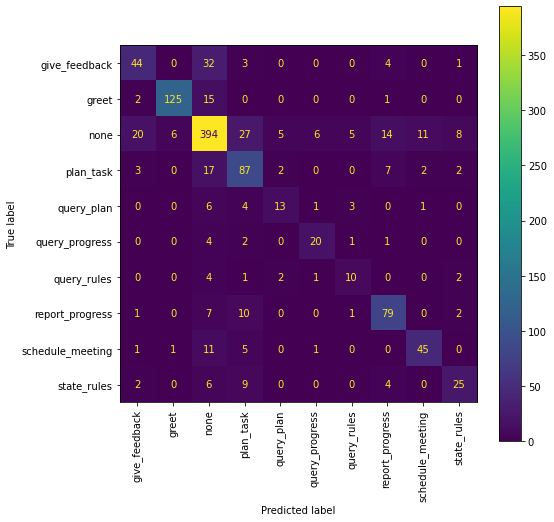

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(logReg, Test_X, Test_Y, display_labels=intents, xticks_rotation='vertical', ax=ax)

In [21]:
# Simple Majority Voting Ensemble (depends on previous classifiers predictions)
#sum_pred = LogRegPredictions.todense() + predictions_SVM.todense() + predictions_NB.todense()

eclf = VotingClassifier(estimators=[ ('nb', Naive), ('svm', SVM),('lr', logReg)], voting='hard')
eclf.fit(Train_X, Train_Y)
ensemble_pred = eclf.predict(Test_X)

#ensemble_pred
score = accuracy_score(ensemble_pred, Test_Y) * 100
f1 = f1_score(ensemble_pred, Test_Y, average='macro')
print("Majority Voting Accuracy: %0.2f"% score)
print("Majority Voting F1 Score: %0.3f"% f1)
print("----------------------------------------------------------")
print(classification_report(Test_Y, ensemble_pred, target_names=intents, digits=2))

Majority Voting Accuracy: 75.02
Majority Voting F1 Score: 0.652
----------------------------------------------------------
                  precision    recall  f1-score   support

   give_feedback       0.67      0.49      0.57        84
           greet       0.94      0.88      0.91       143
            none       0.74      0.86      0.80       496
       plan_task       0.63      0.69      0.66       120
      query_plan       0.60      0.32      0.42        28
  query_progress       0.77      0.61      0.68        28
     query_rules       0.67      0.40      0.50        20
 report_progress       0.78      0.71      0.74       100
schedule_meeting       0.78      0.66      0.71        64
     state_rules       0.64      0.46      0.53        46

        accuracy                           0.75      1129
       macro avg       0.72      0.61      0.65      1129
    weighted avg       0.75      0.75      0.74      1129



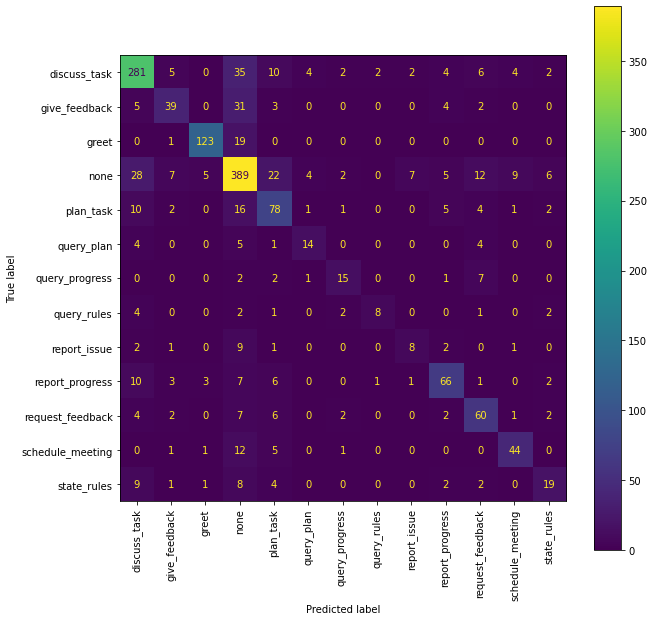

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(eclf, Test_X, Test_Y, display_labels=intents, xticks_rotation='vertical', ax=ax);

## Save model objects for realtime use

In [22]:
import pickle
# save the model to disk
filename = 'ensemble_model.sav'
pickle.dump(eclf, open(filename, 'wb'))
pickle.dump(preprocessor, open('preprocessor.sav', 'wb'))
pickle.dump(Encoder, open('encoder.sav', 'wb'))

In [23]:
#loaded_encoder = pickle.load(open('encoder.sav', 'rb'))


In [22]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder(sparse=False, categories='auto')
Train_Y_oh = oh_encoder.fit_transform(Train_Y.reshape(-1, 1))
Test_Y_oh = oh_encoder.fit_transform(Test_Y.reshape(-1, 1))

In [23]:
# Dense Neural Network
from keras.models import Sequential
from keras import layers

input_dim = Test_X.shape[1]  # Number of features

dense_model = Sequential()
dense_model.add(layers.Dense(20, input_dim=input_dim, activation='relu'))
dense_model.add(layers.Dropout(0.2))
dense_model.add(layers.Dense(Train_Y_oh.shape[1], activation='softmax'))
dense_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

Using TensorFlow backend.


In [24]:
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                80260     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                273       
Total params: 80,533
Trainable params: 80,533
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = dense_model.fit(Train_X, Train_Y_oh, epochs=200, verbose=True, validation_split=0.1, batch_size=300)

Train on 5744 samples, validate on 639 samples
Epoch 1/200
5744/5744 [==============================] - 2s 347us/step - loss: 2.2893 - categorical_accuracy: 0.2819 - val_loss: 2.1326 - val_categorical_accuracy: 0.3005
Epoch 2/200
5744/5744 [==============================] - 1s 111us/step - loss: 2.1663 - categorical_accuracy: 0.3249 - val_loss: 2.0626 - val_categorical_accuracy: 0.3020
Epoch 3/200
5744/5744 [==============================] - 1s 95us/step - loss: 2.1120 - categorical_accuracy: 0.3330 - val_loss: 2.0215 - val_categorical_accuracy: 0.3130
Epoch 4/200
5744/5744 [==============================] - 1s 104us/step - loss: 2.0665 - categorical_accuracy: 0.3416 - val_loss: 1.9916 - val_categorical_accuracy: 0.3302
Epoch 5/200
5744/5744 [==============================] - 1s 117us/step - loss: 2.0338 - categorical_accuracy: 0.3475 - val_loss: 1.9618 - val_categorical_accuracy: 0.3490
Epoch 6/200
5744/5744 [==============================] - 0s 78us/step - loss: 1.9991 - categorical_

Epoch 96/200
5744/5744 [==============================] - 1s 102us/step - loss: 0.7314 - categorical_accuracy: 0.7601 - val_loss: 1.0940 - val_categorical_accuracy: 0.6510
Epoch 97/200
5744/5744 [==============================] - 1s 126us/step - loss: 0.7289 - categorical_accuracy: 0.7584 - val_loss: 1.1003 - val_categorical_accuracy: 0.6463
Epoch 98/200
5744/5744 [==============================] - 1s 99us/step - loss: 0.7117 - categorical_accuracy: 0.7674 - val_loss: 1.1003 - val_categorical_accuracy: 0.6495
Epoch 99/200
5744/5744 [==============================] - 1s 100us/step - loss: 0.7146 - categorical_accuracy: 0.7646 - val_loss: 1.0921 - val_categorical_accuracy: 0.6526
Epoch 100/200
5744/5744 [==============================] - 1s 102us/step - loss: 0.7112 - categorical_accuracy: 0.7745 - val_loss: 1.0928 - val_categorical_accuracy: 0.6557
Epoch 101/200
5744/5744 [==============================] - 0s 83us/step - loss: 0.7120 - categorical_accuracy: 0.7688 - val_loss: 1.1022 - v

Epoch 191/200
5744/5744 [==============================] - 0s 85us/step - loss: 0.4623 - categorical_accuracy: 0.8475 - val_loss: 1.3428 - val_categorical_accuracy: 0.6448
Epoch 192/200
5744/5744 [==============================] - 1s 90us/step - loss: 0.4515 - categorical_accuracy: 0.8552 - val_loss: 1.3466 - val_categorical_accuracy: 0.6463
Epoch 193/200
5744/5744 [==============================] - 1s 92us/step - loss: 0.4530 - categorical_accuracy: 0.8477 - val_loss: 1.3526 - val_categorical_accuracy: 0.6479
Epoch 194/200
5744/5744 [==============================] - 1s 89us/step - loss: 0.4466 - categorical_accuracy: 0.8579 - val_loss: 1.3441 - val_categorical_accuracy: 0.6510
Epoch 195/200
5744/5744 [==============================] - 0s 85us/step - loss: 0.4494 - categorical_accuracy: 0.8506 - val_loss: 1.3449 - val_categorical_accuracy: 0.6463
Epoch 196/200
5744/5744 [==============================] - 0s 75us/step - loss: 0.4455 - categorical_accuracy: 0.8501 - val_loss: 1.3494 - v

In [26]:

loss, accuracy = dense_model.evaluate(Train_X, Train_Y_oh, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

predictions = dense_model.predict(Test_X)
loss, accuracy = dense_model.evaluate(Test_X, Test_Y_oh, verbose=False)

print("Test Accuracy:  {:.4f}".format(accuracy * 100))
print((predictions.shape))
predictions_max = np.argmax(predictions, axis=1)
#Test_Y_max = np.argmax(Test_Y, axis=1)

print("SK-Learn Test Accuracy: ", accuracy_score(predictions_max, Test_Y) * 100)
print("SK-Learn Test Macro F1 Score: ", f1_score(predictions_max, Test_Y, average='macro'))
print("----------------------------------------------------------")
print(classification_report(Test_Y, predictions_max, target_names=intents))

Training Accuracy: 0.9245
Test Accuracy:  66.4787
(1596, 13)
SK-Learn Test Accuracy:  66.47869674185463
SK-Learn Test Macro F1 Score:  0.4862579623771666
----------------------------------------------------------
                  precision    recall  f1-score   support

    discuss_task       0.77      0.75      0.76       357
   give_feedback       0.64      0.33      0.44        84
           greet       0.95      0.85      0.89       143
            none       0.59      0.83      0.69       496
       plan_task       0.54      0.47      0.50       120
      query_plan       0.50      0.14      0.22        28
  query_progress       0.50      0.29      0.36        28
      query_tool       0.00      0.00      0.00        20
    report_issue       0.33      0.12      0.18        24
 report_progress       0.64      0.56      0.60       100
request_feedback       0.65      0.62      0.63        86
schedule_meeting       0.73      0.64      0.68        64
      state_tool       0.69     

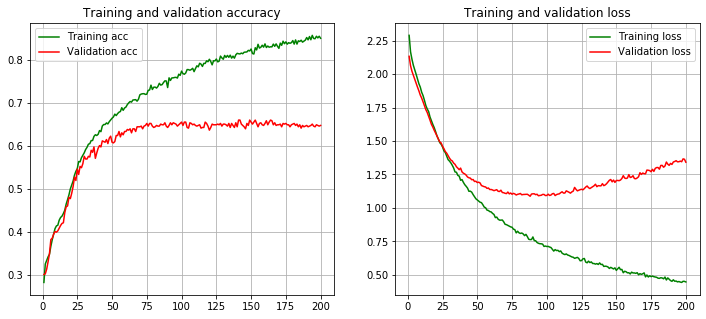

In [27]:
plot_history(history)

## Cross Validation Results

In [43]:
scoring = ['accuracy', 'f1_macro', 'f1_weighted']
clfs = {
    'NB': Naive,
    'SVM': SVM,
    'LogReg': logReg,
    'MV Ensemble': eclf
}
for lbl in clfs.keys():
    scores = cross_validate(clfs[lbl], Train_X, Train_Y, scoring=scoring, cv=10)
    # standard deviation = range / 4
    print('Accuracy for %s: %0.2f (+/- %0.2f)' %(lbl, scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print('Macro F1 for %s: %0.2f (+/- %0.2f)' %(lbl, scores['test_f1_macro'].mean(), scores['test_f1_macro'].std() * 2))
    print('Weighted F1 for %s: %0.2f (+/- %0.2f)' %(lbl, scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std() * 2))
    print()

Accuracy for NB: 0.69 (+/- 0.04)
Macro F1 for NB: 0.48 (+/- 0.06)
Weighted F1 for NB: 0.65 (+/- 0.04)

Accuracy for SVM: 0.76 (+/- 0.03)
Macro F1 for SVM: 0.64 (+/- 0.06)
Weighted F1 for SVM: 0.75 (+/- 0.03)

Accuracy for LogReg: 0.77 (+/- 0.03)
Macro F1 for LogReg: 0.67 (+/- 0.06)
Weighted F1 for LogReg: 0.77 (+/- 0.03)

Accuracy for MV Ensemble: 0.77 (+/- 0.03)
Macro F1 for MV Ensemble: 0.65 (+/- 0.06)
Weighted F1 for MV Ensemble: 0.76 (+/- 0.03)



# Error Analyses

In [44]:
predictions = ensemble_pred
expected = Encoder.inverse_transform(Test_Y)
actual = Encoder.inverse_transform(predictions)
errors = errors = np.zeros((len(intents), len(intents)))
for ex in range(0, Test_X.shape[0]):
    if actual[ex] != expected[ex]:
        errors[Test_Y[ex]][predictions[ex]] += 1

In [45]:
print("%7.5s"*(len(intents)+2) %('', *intents, 'Total'))
for i in range(0, len(intents)):
    print("%7.5s"*(len(intents)+2) %(intents[i], *errors[i], sum(errors[i])))
print("%7.5s"*(len(intents)+2) %("Total", *np.sum(errors, axis=0), ''))

         give_  greet   none  query  query  query  repor  repor  reque  sched  Total
  give_    0.0    0.0   36.0    0.0    0.0    0.0    0.0    5.0    2.0    0.0   43.0
  greet    1.0    0.0   17.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   18.0
   none   13.0    5.0    0.0    3.0    3.0    3.0    5.0    5.0   14.0    8.0   59.0
  query    0.0    1.0    7.0    0.0    1.0    0.0    0.0    0.0    6.0    2.0   17.0
  query    0.0    0.0    3.0    0.0    0.0    0.0    0.0    1.0    6.0    0.0   10.0
  query    0.0    0.0    6.0    1.0    1.0    0.0    0.0    0.0    3.0    0.0   11.0
  repor    1.0    0.0   11.0    0.0    1.0    0.0    0.0    2.0    0.0    1.0   16.0
  repor    2.0    1.0   17.0    0.0    0.0    1.0    1.0    0.0    1.0    0.0   23.0
  reque    2.0    0.0   15.0    1.0    1.0    0.0    0.0    1.0    0.0    2.0   22.0
  sched    1.0    0.0   20.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   22.0
  Total   20.0    7.0  132.0    5.0    8.0    4.0    6.0   14.0  

In [46]:
def get_errors(true_label=None, pred_label=None):
    if true_label:
        true_index = intents.index(true_label)
    if pred_label:
        pred_index = intents.index(pred_label)
    print("Searching for \"", true_label, "\" misclassified as \"", pred_label,"\"")
    error_list = (Test_X_raw[(Test_Y != ensemble_pred) & (Test_Y == true_index) & (ensemble_pred == pred_index)])
    print('found', error_list.shape[0], 'errors')
    return error_list.drop(['id'], axis=1)
list(get_errors('query_progress', "request_feedback")['text'])

Searching for " query_progress " misclassified as " request_feedback "
found 6 errors


['can you tell me what we reach ?',
 'have you guys seen the  MABotArtifact  and  MABotArtifact  ?',
 ' MABotPerson  nasar could please check with  MABotPerson  and give us your update',
 'hi we need to know if they have tested your  MABotArtifact  ? it worked our  MABotArtifact  or you want to change something ?',
 ' MABotPerson  please inform me if the  MABotPerson  problem solved or not',
 'all please let me know if you did not or not just to make sure all have finished it']

In [46]:
list(get_errors("request_feedback", "plan_task")['text'])

Searching for " request_feedback " misclassified as " plan_task "
found 6 errors


['should i do any more changes to events  MABotArtifact ',
 'please refer my  MABotArtifact  which is updated  MABotArtifact  in forum',
 'will go through it and will come back to you if we have any query',
 'all our  MABotSubteam  team have finished the first task we need to check it with the other teams to submit it before MABotEntTime',
 'hi friends we need to submit the project tomorrow please do respond to us',
 'me and  MABotPerson  are going to analyze the care center  MABotArtifact  here as to make it clear to anyone ok ?']

In [47]:
list(get_errors("report_progress", "plan_task")['text'])

Searching for " report_progress " misclassified as " plan_task "
found 6 errors


['we upload an  MABotArtifact  that would be the  MABotArtifact  with the  MABotArtifact ',
 'hello team we work in the  MABotArtifact ',
 'i have put a static  MABotArtifact  for that last  MABotArtifact ',
 'we still thinking on data requiremnt about event  MABotArtifact  so me and my proj mate chao wang will discuss on it',
 'hi guys i upload a  MABotArtifact  which is the  MABotArtifact  for the support us if any thing change i will leave a message here',
 'we will post our feedback about relational diagrams soon']

In [48]:
list(get_errors("give_feedback", "none")['text'])

Searching for " give_feedback " misclassified as " none "
found 31 errors


[' MABotPerson  right',
 'good team work',
 'fine  MABotPerson ',
 ' MABotPerson  sure thanks for the  MABotArtifact ',
 'it think its okay',
 'ok that is good news',
 'of course i am interested in the project and its really nice working with you all as a team',
 ' MABotPerson  yes i highly recommend this as well',
 'yes good',
 'ah okay',
 ' MABotPerson  very thing is ok',
 'yes iam with  MABotPerson ',
 'it better but how to do that',
 'sure  MABotPerson ',
 ' MABotPerson  i have some observations on your  MABotArtifact ',
 ' MABotPerson  ok no problem for me',
 'the previous was partially correct the latest one is wrong according to me',
 ' MABotPerson   MABotPerson  i have no problem',
 'myself and  MABotPerson   MABotPerson  are objecting about it',
 'so far i am good if i need some help i will let you know',
 'to be honest I am not convinced  MABotArtifact ',
 'it is showing me an error',
 'yes this is my opinion too',
 'that all thank you very much',
 'okay no problem',
 'thanks